# 线性回归从0开始实现

In [43]:
#将图片嵌入jupyter lab，而不是打开一个新的窗口
%matplotlib inline 
import random 
import torch
from d2l import torch as d2l

In [44]:
#生成数据集
def synthetic_data(w,b,num_examples):
    """生成y=Xw+b+噪音"""
    # torch.normal(mean, std, size)用于生成服从正太分布的随机数张量
    #mean:正态分布的均值
    #std:正态分布的标准差
    #suze:生成的随机张量的形状
    X = torch.normal(0,1,(num_examples,len(w)))
    #矩阵乘法并使用广播机制求出y值
    y = torch.matmul(X,w) + b
    #给y添加上一些噪音
    y += torch.normal(0,0.01,y.shape)
    # 返回自变量X，和一列向量y
    return X,y.reshape((-1,1))

In [45]:
# 自己设置的权重和截距，后续可以查看训练出来的结果是否等于这个值
true_w = torch.tensor([2,-3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

features: tensor([-1.1900,  1.5213]) 
label: tensor([-3.3377])


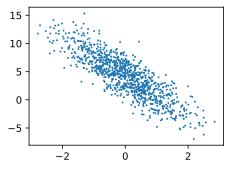

In [46]:
print('features:', features[0],'\nlabel:', labels[0])
d2l.set_figsize()
d2l.plt.scatter(features[:, (1)].detach().numpy(), labels.detach().numpy(), 1);

In [47]:
# torch中的张量可以使用张量来进行索引
import torch

# 创建一个二维张量
tensor = torch.tensor([[1, 2, 3], [4, 5, 6], [7, 8, 9]])

# 创建一个包含行索引和列索引的张量
row_indices = torch.tensor([0, 2])
col_indices = torch.tensor([1, 2])

# 使用多维索引张量来选择元素
selected_elements = tensor[row_indices, col_indices]
print(selected_elements)  # 输出: tensor([2, 9])


tensor([2, 9])


In [48]:
# 读取数据集
# 定义一个函数来不断接受小批量的数据
def data_iter(batch_size,features,labels):
    num_examples = len(features)
    # range(start,stop,step)用于生成一系列整数，它的返回值是一个可迭代对象，
    # 如果想要把它转换成列表的话，可以使用list()函数
    indices = list(range(num_examples))
    # random.shuffle()打乱列表中的元素顺序，生成一个随机的排列，会直接在原列表上进行操作，
    # 而不生成一个新的列表
    random.shuffle(indices)
    # 设置一个循环，该循环的次数等于 样本总数/单次处理数据的数
    for i in range(0,num_examples,batch_size):
    #torch.tensor(data, dtype=None, device=None, requires_grad=False)
        batch_indices = torch.tensor(
            indices[i:min(i + batch_size,num_examples)])
        # 使用函数时索引或者其它方面请求一个值，yield才会返回一个值
        yield features[batch_indices],labels[batch_indices]
batch_size = 10
for X,y in data_iter(batch_size,features,labels):
    print(X,'\n',y)
    break
    


tensor([[-1.6536,  0.9592],
        [ 0.5191, -0.0796],
        [-0.2652,  0.9848],
        [ 1.4038,  0.2622],
        [ 1.1006, -0.2395],
        [-1.0861, -0.2546],
        [-0.6393, -0.6683],
        [-1.5907,  0.5691],
        [-1.4326, -0.1203],
        [-1.7345, -0.5307]]) 
 tensor([[-2.3704],
        [ 5.5128],
        [ 0.3170],
        [ 6.1219],
        [ 7.2153],
        [ 2.8860],
        [ 5.1660],
        [-0.9082],
        [ 1.7561],
        [ 2.5343]])


In [49]:
# 初始化模型参数
w = torch.normal(0,0.01,size = (2,1),requires_grad=True)
b = torch.zeros(1,requires_grad=True)

In [50]:
# 定义模型
def linreg(X,w,b):
    return torch.matmul(X,w)+b
# 定义损失函数
def squared_loss(y_hat,y):
    #返回一个平方损失函数
    return (y_hat-y.reshape(y_hat.shape))**2/2 

In [51]:
# 定义优化函数
# 虽然线性回归有解析解，但这里我们仍然使用梯度下降的方法
def sgd(params,lr,batch_size):
    # 禁用梯度跟踪来提高效率
    with torch.no_grad():
        for param in params:
            param -= lr*param.grad / batch_size
            #清空梯度，防止梯度累积
            param.grad.zero_()

In [52]:
# 设置学习率为0.03
lr = 0.03
# 设置迭代次数
num_epochs = 3
#给函数起一个别名
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  # X和y的小批量损失
        # 因为l形状是(batch_size,1)，而不是一个标量。l中的所有元素被加到一起，
        # 并以此计算关于[w,b]的梯度
        l.sum().backward()
        sgd([w, b], lr, batch_size)  # 使用参数的梯度更新参数
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.048983
epoch 2, loss 0.000202
epoch 3, loss 0.000047


In [53]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([-0.0004, -0.0008], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0008], grad_fn=<RsubBackward1>)
